In [1]:
import sys
# in order that the parent directory can be accessed, as this notebook
# is in the 'notebooks/' subdirectory
sys.path[1:1] = ['..']
%load_ext autoreload
%autoreload 2

In [2]:
from bayesianAB.event_stream import one_simulation_until_stopping_condition
import pandas as pd

In [3]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# See my blog post here:  http://aaronmcdaid.com/blog.posts/multiplot_from_generator/
from notebook_utils import multiplot_from_generator

In [43]:
from octotools.cache import Cache
cache = Cache()

## No true difference

If there is zero difference between the two means, then both the _expected loss_ and the _expected gain_ will tend towards zero. If there truly is a positive effect, the expected gain will tend towards the true positive effect, and the expected loss will tend to zero. And finally, if there truly is a negative effect, then the expected loss will tend towards the true effect and the expected gain will tend towards zero.

We see this in the next few plots. The first plot is just one experiment running to a sample size of 100, plotting the expected loss (EL, blue) and the expected gain (EG, orange).

The second plot shows 25 experiments, each running up to a sample size of 500, with the 25 traces of EL on top of each other. The third plot is the same as the second, but with a small positive true effect in order to show that the EL tends towards zero more quickly.

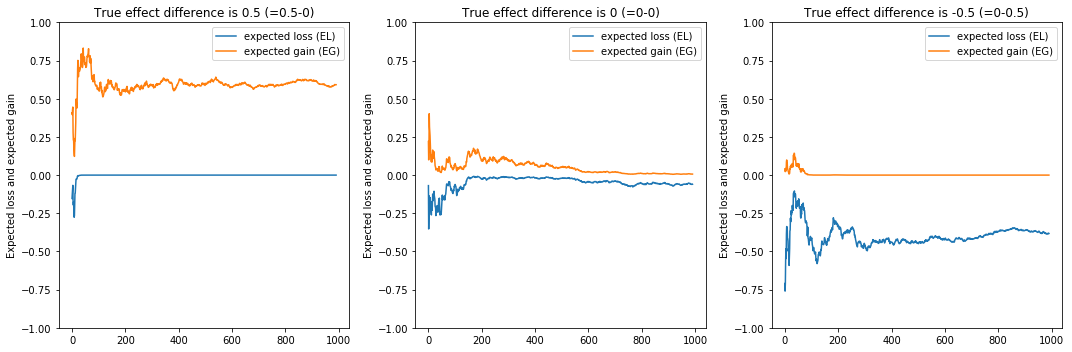

In [5]:
stopping_condition = 'total_sample_size == 1000'

def _plotter():
    for means in [([0, 0.5]), ([0,0]), ([0.5, 0])]:
        sim = one_simulation_until_stopping_condition(
            weights = [0.5, 0.5],
            means = means,
            stdevs = [1, 1],
            stopping_condition = stopping_condition)
        yield # 'multiplot_from_generator' requires a 'yield' before each plot
        plt.plot(sim.expected_loss, label='expected loss (EL)');
        plt.plot(sim.expected_gain, label='expected gain (EG)');
        plt.title('True effect difference is {} (={}-{})'.format(means[1]-means[0], means[1], means[0]))
        plt.ylabel('Expected loss and expected gain')
        plt.tight_layout()
        plt.ylim(-1, 1)
        plt.legend()
        
multiplot_from_generator(_plotter(), 3)

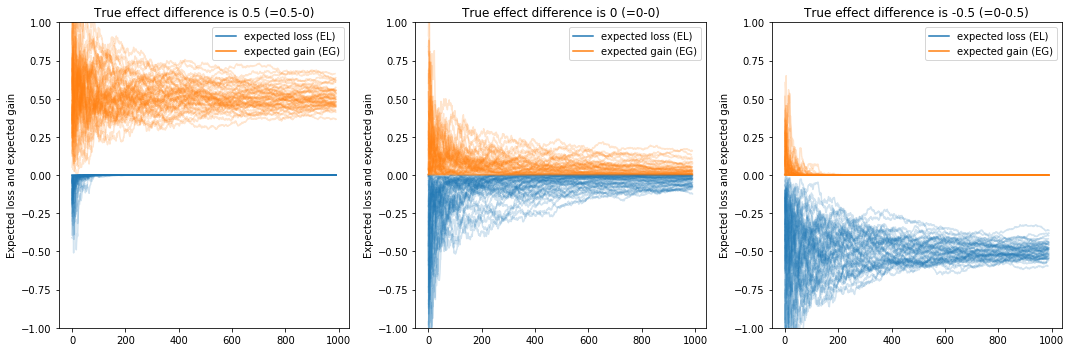

In [6]:
stopping_condition = 'total_sample_size >= 1000'
NUMBER_OF_SIMULATIONS=50

def _plotter():
    for means in [([0, 0.5]), ([0,0]), ([0.5, 0])]:
        
        yield # 'multiplot_from_generator' requires a 'yield' before each figure
        
        # First, two 'fake' plots to get a nice legend and store the colours
        el_line, = plt.plot([], [], label='expected loss (EL)');
        eg_line, = plt.plot([], [], label='expected gain (EG)');
        plt.legend()
        
        # Now do all the simulations, plotting EL and EG for each
        for _ in range(NUMBER_OF_SIMULATIONS):
            sim = one_simulation_until_stopping_condition(
                weights = [0.5, 0.5],
                means = means,
                stdevs = [1, 1],
                stopping_condition = stopping_condition)
            # plotting, with the correct colour
            plt.plot(sim.expected_loss, color=el_line.get_color(), alpha=0.2)
            plt.plot(sim.expected_gain, color=eg_line.get_color(), alpha=0.2)
        plt.title('True effect difference is {} (={}-{})'.format(means[1]-means[0], means[1], means[0]))
        plt.ylabel('Expected loss and expected gain')
        plt.tight_layout()
        plt.ylim(-1, 1)
        
multiplot_from_generator(_plotter(), 3)

## "Threshold of caring"

The _threshold of caring_ is a heuristic used to decide when to stop the experiment. If we set the _threshold of caring_ to 

$$\tau=0.01$$

then we run the experiment until either:

$$  EL > -\tau $$
or
$$  EG < \tau $$

To investigate this, we need to run simulations where we specify:

 - the true effect, $\Delta$, which is the difference in the true means
 - the _threshold of caring_, $toc$

and then we analyse the final values, after the threshold has been reached, of these three quantities:

 - EL
 - EG
 - estimated effect, $\hat\Delta$, i.e. the difference between the estimate sample means

In [ ]:
# Note: this function ensures that each variant has at least 100 observations
def many_simulations_to_the_stopping_condition(runs, stopping_condition, true_difference, true_stdev, weights):
    
    def _one_simulation(simulation_number):
        print(simulation_number, end=' ')
        sim = one_simulation_until_stopping_condition(
            weights = weights,
            # the absolute value of the means doesn't matter, just the difference between them
            means = [7, 7+true_difference],
            stdevs = [true_stdev, true_stdev],
            stopping_condition = stopping_condition,
            min_sample_size = 100,
        )
        data_to_keep = sim[['total_sample_size', 'expected_loss', 'expected_gain']].copy()
        data_to_keep['simulation#'] = simulation_number
        return data_to_keep
        
    many_runs = [_one_simulation(simulation_number) for simulation_number in range(runs)]
    print()
    return pd.concat(many_runs).reset_index(drop=True)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
CPU times: user 1min 2s, sys: 824 ms, total: 1min 2s
Wall time: 1min 2s


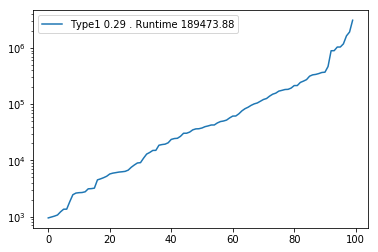

In [220]:
stopping_condition = """expected_loss > -0.001 | expected_gain < 0.01"""

is_ups = []
sample_sizes = []
%time df = many_simulations_to_the_stopping_condition(100, stopping_condition, 0, 8, [0.10, 0.90])
x = df.query(stopping_condition).groupby('simulation#').tail(1)
for i in range(x.shape[0]):
    last_row = x.iloc[i]
    is_up = (last_row.expected_loss / -0.001) < (last_row.expected_gain /  0.01)
    #print()
    #print(sim, is_up)
    assert last_row.expected_loss > -0.001 or last_row.expected_gain < 0.01
    if is_up:
        assert last_row.expected_loss > -0.001
    else:
        assert last_row.expected_gain < 0.01
    is_ups.append(is_up)
    sample_sizes.append(last_row.total_sample_size)
    
Type1 = np.mean(is_ups)
plt.semilogy(sorted(sample_sizes))
plt.legend(['Type1 {} . Runtime {}'.format(Type1,np.mean(sample_sizes))])

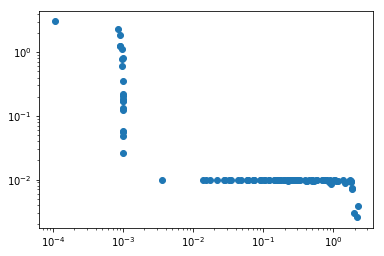

In [212]:
for_scatter = df.groupby('simulation#').tail(1)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.scatter(-for_scatter.expected_loss, for_scatter.expected_gain)


In [198]:
foo

NameError: name 'foo' is not defined

In [26]:
# Note: this function ensures that each variant has at least 100 observations
def many_simulations_to_the_threshold(runs, threshold_of_caring, true_difference, true_stdev, weights):
    # if either EL or EG reach the threshold_of_caring, then end
    stopping_condition = """expected_loss > -{} | expected_gain < {}""".format(threshold_of_caring, threshold_of_caring)
    
    def _one_simulation(simulation_number):
        print(simulation_number, end=' ')
        sim = one_simulation_until_stopping_condition(
            weights = weights,
            # the absolute value of the means doesn't matter, just the difference between them
            means = [7, 7+true_difference],
            stdevs = [true_stdev, true_stdev],
            stopping_condition = stopping_condition,
            min_sample_size = 100,
        )
        data_to_keep = sim[['total_sample_size', 'expected_loss', 'expected_gain']].copy()
        data_to_keep['simulation#'] = simulation_number
        return data_to_keep
        
    many_runs = [_one_simulation(simulation_number) for simulation_number in range(runs)]
    print()
    return pd.concat(many_runs).reset_index(drop=True)

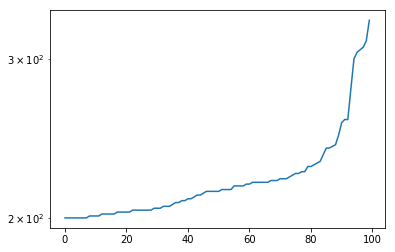

In [60]:
def cached_many_simulations_to_the_threshold(*l, **kw):
    with cache:
        return cache.simple('many_simulations_to_the_threshold', 'many_simulations_to_the_threshold', l, kw)
    
many = cached_many_simulations_to_the_threshold(
                        runs=100,
                        threshold_of_caring=0.03,
                        true_difference=0,
                        true_stdev=1,
                        weights=[0.5, 0.5],
)
x = many.groupby('simulation#')['total_sample_size'].max().sort_values()
plt.semilogy(x.tolist());

In [67]:
for runs in [100, 1000]:
    for true_diff in [0, 0.01, 0.1]:
            print(runs, true_diff)
            cached_many_simulations_to_the_threshold(
                        runs=runs,
                        threshold_of_caring=0.0003,
                        true_difference=true_diff,
                        true_stdev=1,
                        weights=[0.5, 0.5],
                        )

100 0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
100 0.01
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
100 0.1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 
1000 0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [138]:
# call the cached_many_simulations_to_the_threshold to generate many
# simulations, then apply the 'new_threshold_of_caring' and find the
# first event in each simulation which attains that threshold.
def find_end_of_each_simulation(new_threshold_of_caring, *l, **kw):
    many_sims = cached_many_simulations_to_the_threshold(*l, **kw)
    stopping_condition = """expected_loss > -{} | expected_gain < {}""".format(new_threshold_of_caring, new_threshold_of_caring)
    #return many_sims.query(stopping_condition).groupby('simulation#').apply(lambda df: df.iloc[0,])
    return many_sims.groupby('simulation#').apply(lambda df: df.query(stopping_condition).iloc[0,])

def cached_find_end_of_each_simulation(*l, **kw):
    with cache:
        return cache.simple('Find_end_of_each_simulation', 'find_end_of_each_simulation', l, kw)

In [139]:
REGEL_RATIO = 10

In [140]:
def plot_decisions(new_toc, end_of_each_simulation):
    EG = np.maximum(new_toc, end_of_each_simulation.expected_gain)
    EL = np.maximum(new_toc, -end_of_each_simulation.expected_loss)
    REGEL = EG / EL
    sorted_REGEL = REGEL.sort_values()
    decide_down = (sorted_REGEL < 1/REGEL_RATIO).mean()
    decide_up   = (sorted_REGEL >   REGEL_RATIO).mean()
    decide_no   = 1-decide_down-decide_up
    print(decide_down, decide_no, decide_up)
    plt.semilogy(sorted_REGEL.tolist())
    plt.axhline(REGEL_RATIO, color='grey', linestyle='--')
    plt.axhline(1/REGEL_RATIO, color='grey', linestyle='--')

             total_sample_size  expected_loss  expected_gain  simulation#
simulation#                                                              
0                        451.0      -0.231086       0.000296          0.0
1                      10801.0      -0.034477       0.000298          1.0
2                       2493.0      -0.000293       0.082517          2.0
3                     101501.0      -0.008267       0.000299          3.0
4                       6749.0      -0.046140       0.000293          4.0
0.488 0.07 0.442


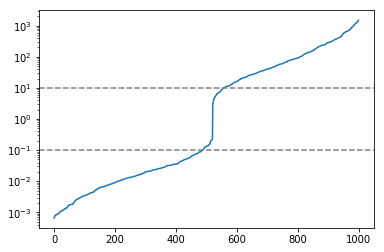

In [143]:
new_toc = 0.01
new_toc = 0.001
new_toc = 0.003
new_toc = 0.0003
endings = cached_find_end_of_each_simulation(new_toc, 
                        runs=1000,
                        threshold_of_caring=0.0003,
                        true_difference=0,
                        true_stdev=1,
                        weights=[0.5, 0.5],
                                     )
print(endings.head())
plot_decisions(new_toc, endings)

In [134]:
def to_NaN_if_False(series, b):
    s = series.copy()
    s[~b] = np.nan
    return s
def histogram(**kw):
    plt.figure()
    sims = simulate_to_the_threshold(**kw)
    
    # Check which of the stopping conditions was reached first:
    sims['is_up'] = sims.EG_toc_ratio > sims.EL_toc_ratio
    
    # Two sample size histograms - for positive and negative outcome
    sims['- effect'] = to_NaN_if_False(-sims.total_sample_size, ~sims.is_up)
    sims['+ effect'] = to_NaN_if_False(sims.total_sample_size, sims.is_up)
    sims[['+ effect', '- effect']].plot.hist(alpha=0.5, linewidth=4, bins=10)
    
    # How many runs ended in a positive effect?
    prop_positive = np.mean(sims.is_up)
    # ... and what was the average sample size for both sets of runs?
    two_average_runtimes = sims.groupby('is_up')['total_sample_size'].mean().to_dict()
    title_string = """{:.1f}% ended with positive outcome.
        Average runtime when negative $(positive)$: {:.1f} $({:.1f})$
        """.format(prop_positive*100, two_average_runtimes.get(False, np.nan), two_average_runtimes.get(True, np.nan ))
    plt.suptitle(title_string)